In [47]:
import pandas as pd, numpy as np 
np.random.seed(0)

import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from helper import LabelEncoderExt
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.tree import plot_tree, export_text

plt.rcParams["figure.figsize"] = (20,5)

In [48]:
df = pd.read_csv("input/covid_train.csv")
df

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,50s,MALE,NO KNOWN EPI LINK,Oakville,NaN,43.413997,-79.744796,Resolved
1,20s,FEMALE,CC,Guelph,NaN,43.524881,-80.233743,Not Resolved
2,90s,FEMALE,OB,Barrie,Yes,44.410713,-79.686306,Resolved
3,20s,FEMALE,MISSING INFORMATION,Toronto,NaN,43.656591,-79.379358,Resolved
4,90s,FEMALE,OB,Ottawa,Yes,45.345665,-75.763912,Fatal
...,...,...,...,...,...,...,...,...
14846,<20,FEMALE,CC,Hamilton,NaN,43.257631,-79.871341,Not Resolved
14847,20s,FEMALE,NO KNOWN EPI LINK,Mississauga,NaN,43.647471,-79.708893,Not Resolved
14848,80s,MALE,OB,Thorold,Yes,43.116537,-79.241220,Fatal
14849,50s,FEMALE,CC,Newmarket,NaN,44.048023,-79.480239,Fatal


#### Notes for understanding the data better

1. Cases with no known epidemiological link are those where a likely exposure could not be
determined (i.e. the cases were not reported to be linked to an outbreak or have contact with another
confirmed case)

2. "What (an outbreak) means is that there is some kind of uncontrolled, undesired transmission of infection," https://www.ctvnews.ca/health/coronavirus/what-constitutes-a-covid-19-outbreak-experts-say-classification-isn-t-clear-cut-1.5105548

3. Assumming ‘No Info-Missing’ is just a missing piece of information and ‘No Info-Unknown’ means that there is no epidemiological link such as CC, Travel or Outbreak. Therefore I may ‘No Info-Unknown’ into "NO KNOWN EPI LINK".

4. Epidemiologically linked case: a case in which the patient has/has had contact with one or more persons who have/had the disease, and transmission of the agent by the usual modes of transmission is plausible. A case may be considered epidemiologically linked to a laboratory-confirmed case if at least one case in the chain of transmission is laboratory confirmed.

5. Resolved: aaffected individuals either died or recovered.

6. No-epi = community spread: Community transmission is evidenced by the inability to relate confirmed cases through chains of transmission for a large number of cases, or by increasing positive tests through sentinel samples (routine systematic testing of respiratory samples from established laboratories).

In [49]:
df.isna().sum(axis=0)

Age_Group                     6
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           9020
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
Outcome1                      0
dtype: int64

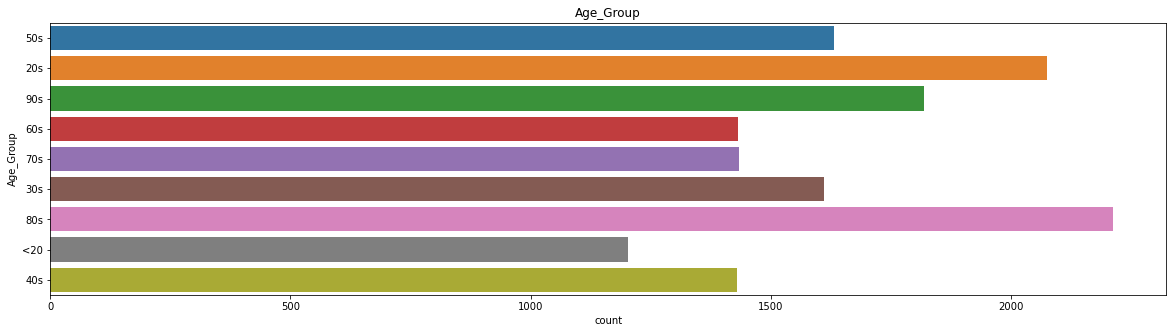

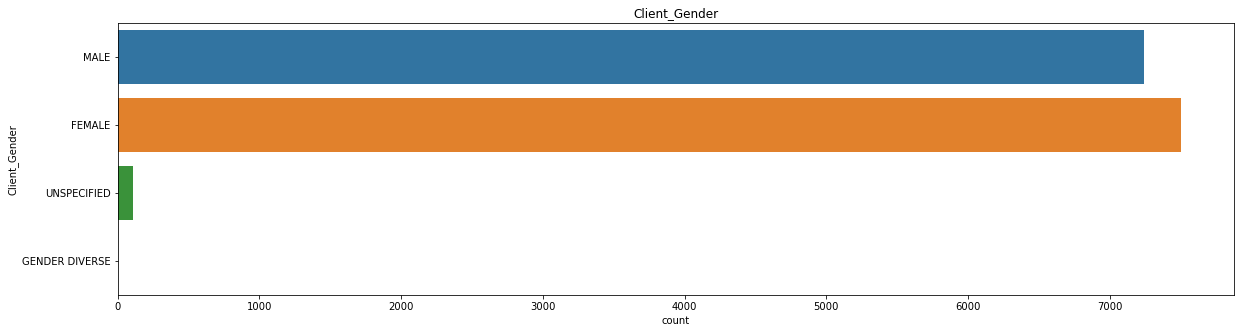

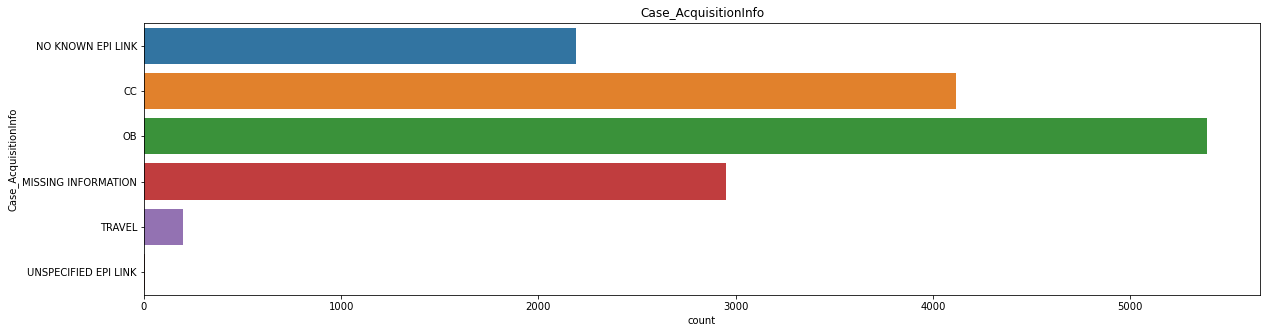

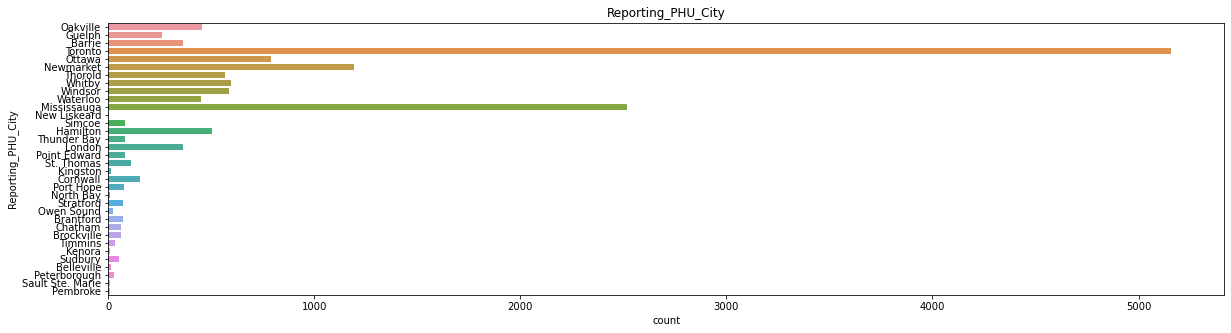

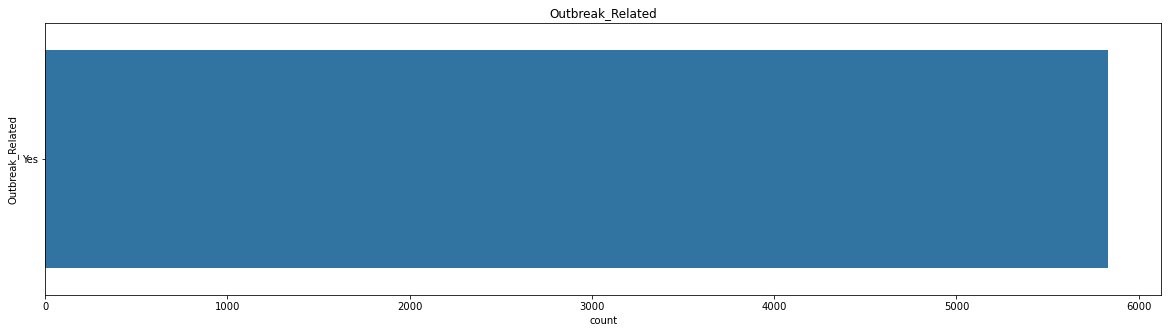

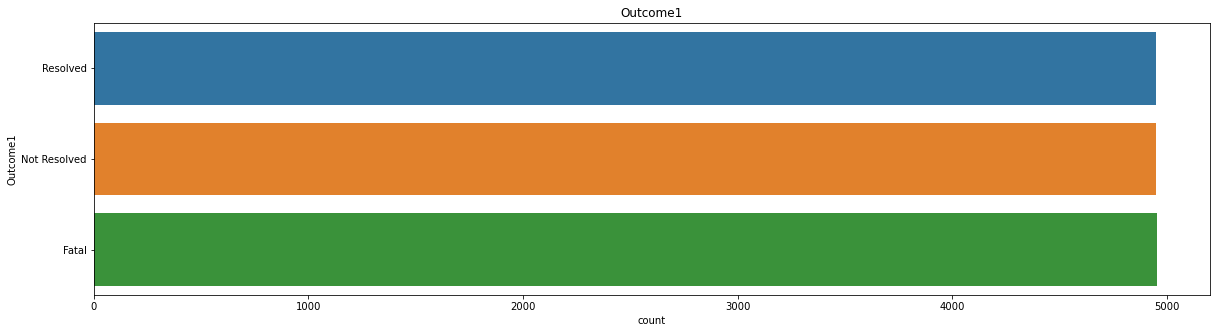

In [50]:
for col in df.select_dtypes(object):
    plt.figure()
    ax = sns.countplot(y=df[col], orient='v')
    ax.set_title(col)

# Question 1

#### General Pre-processing

I have assummed that age categories are pre-defined in the system and any possible future case will have feature values that lies within those categories (90s including above 90s as well). I can therefore, perform encoding prior to splitting dataset into train/test splits.

> Note: As it was discussed on Piazza that Missing Acquisition Information and Unspecified Epi-Link are not NaNs, I am not filtering them out. However, I am combining the two of them into Missing Information.

For tree-based classifiers and NB, separate pre-processing is also applied in this notebook.

In [51]:
df.loc[df['Outbreak_Related'].isna(),'Outbreak_Related'] = "No"

# Adding this filter based on TA's comments in @404
df.loc[df['Client_Gender'] == "UNSPECIFIED", 'Client_Gender'] = np.nan

df = df.dropna()

df.loc[df['Case_AcquisitionInfo'] == "UNSPECIFIED EPI LINK", "Case_AcquisitionInfo"] = "MISSING INFORMATION"

age_encoder = OrdinalEncoder([['<20', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']]).fit(np.array(df['Age_Group']).reshape(-1, 1))
df['Age_Group'] = age_encoder.transform(np.array(df['Age_Group']).reshape(-1 ,1))
df['Outbreak_Related'] = pd.get_dummies(df['Outbreak_Related'], drop_first=True)

# To make use of this dataframe for preprocessing for NB models
df_NB = df.copy()

Text(0.5, 1.0, 'Outcome1')

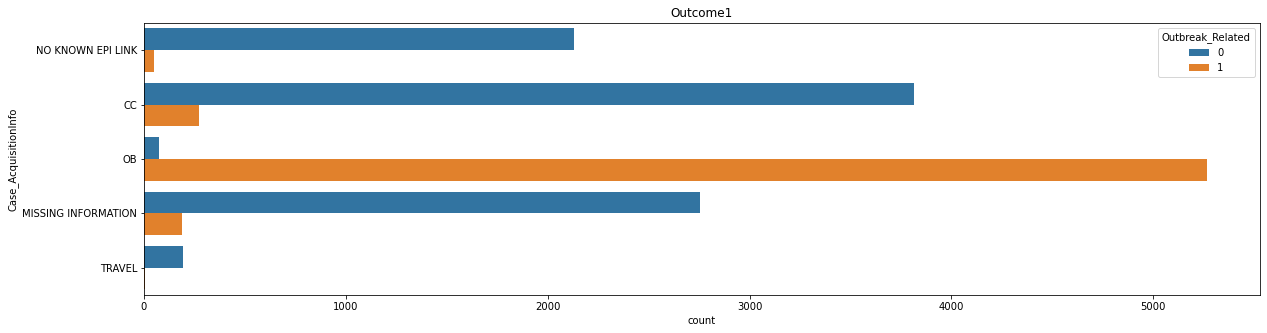

In [52]:
ax = sns.countplot(y=df['Case_AcquisitionInfo'], orient='v', hue=df['Outbreak_Related'])
ax.set_title(col)

This is weird because if `Case_AcquisitionInfo` is not OB then how can it be `Outbreak_Related`. In my analysis, I am assumming such inconsistent records.

Text(0.5, 1.0, 'Outcome1')

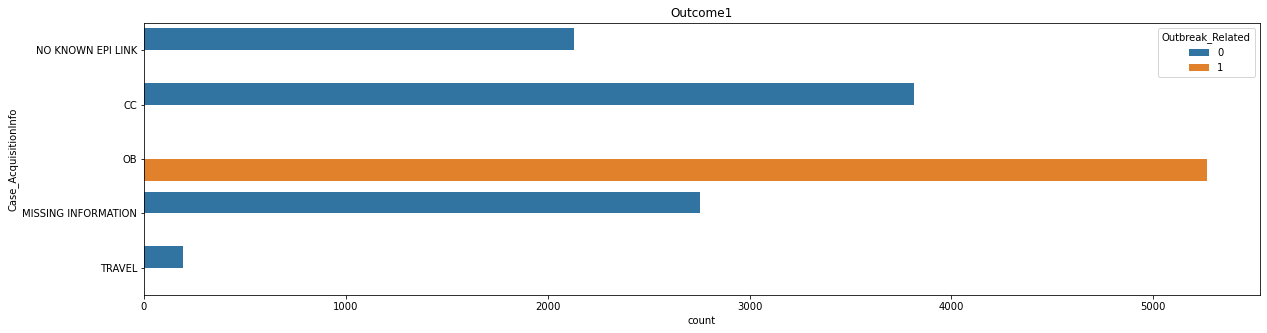

In [53]:
df = df.drop(df[(df['Case_AcquisitionInfo'] != "OB") & (df['Outbreak_Related'] == 1)].index, axis=0)
df = df.drop(df[(df['Case_AcquisitionInfo'] == "OB") & (df['Outbreak_Related'] == 0)].index, axis=0)
ax = sns.countplot(y=df['Case_AcquisitionInfo'], orient='v', hue=df['Outbreak_Related'])
ax.set_title(col)

> That's more like it!

#### Pre-preocessing specific to Tree-based models

I am using OrdinalEncoder() for age groups since `Age_Group` is ordinal categorical variable. I am dropping `Reporting_PHU_City` since I already have that information in terms of continous longitude/latitude values. For the rest of the categorical variables, I am using dummy encoding.


#### Feature Scaling


While for most of the algorithms, the model accuracy and convergence to cost minima can be improved considerably when the features are on the same scale, Naive Bayes classifier is invariant to features having varying range of magnitudes and thus, do not require feature scaling.

Tree-based classifiers are known for their inherent ability to select the most improtant features and to determine their corresponding splits without being affected if the features are on the same scale or not. After all, the splits always happen one feature at a time.

> #### Therefore, feature scaling is not being performed.

In [54]:
df = df.drop(columns=['Reporting_PHU_City'])
df = pd.concat([df.drop(columns=['Client_Gender']), pd.get_dummies(df['Client_Gender'], prefix='Gender', drop_first=True)], axis=1)
df = pd.concat([df.drop(columns=['Case_AcquisitionInfo']), pd.get_dummies(df['Case_AcquisitionInfo'], prefix='Case_AcquisitionInfo', drop_first=True)], axis=1)
df

,Age_Group,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1,Gender_GENDER DIVERSE,Gender_MALE,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL
0,4.0,0,43.413997,-79.744796,Resolved,0,1,0,1,0,0
1,1.0,0,43.524881,-80.233743,Not Resolved,0,0,0,0,0,0
2,8.0,1,44.410713,-79.686306,Resolved,0,0,0,0,1,0
3,1.0,0,43.656591,-79.379358,Resolved,0,0,1,0,0,0
4,8.0,1,45.345665,-75.763912,Fatal,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
14846,0.0,0,43.257631,-79.871341,Not Resolved,0,0,0,0,0,0
14847,1.0,0,43.647471,-79.708893,Not Resolved,0,0,0,1,0,0
14848,7.0,1,43.116537,-79.241220,Fatal,0,1,0,0,1,0
14849,4.0,0,44.048023,-79.480239,Fatal,0,0,0,0,0,0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Outcome1']), df['Outcome1'], test_size = 0.2, random_state=0)

## Part 1

### Decision Tree

In [58]:
def cross_validate_tree(X_train, y_train, max_depths, min_samples_split=2, min_samples_leaf=2, random_state=0, folds = 10):
    training_accuracy = []
    mean_cv_accuracy = []
    for max_depth in max_depths:
        if max_depth == "None":
            max_depth = None

        dt_init = DecisionTreeClassifier(criterion='gini',
        splitter='best',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state)

        cv_scores = cross_val_score(dt_init, X_train, y_train, cv=folds)
        mean_cv_accuracy.append(cv_scores.mean()) 
        training_accuracy.append(dt_init.fit(X_train, y_train).score(X_train, y_train))


    return mean_cv_accuracy, training_accuracy

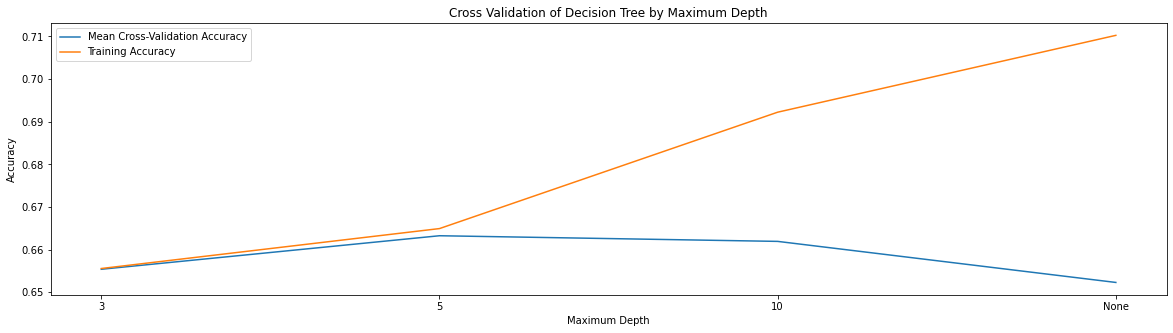

In [59]:
max_depths = [3, 5, 10, "None"]
mean_cv_accuracy, training_accuracy = cross_validate_tree(X_train, y_train, max_depths, min_samples_split=2, min_samples_leaf=2, random_state=0, folds = 10)
plt.plot(max_depths, mean_cv_accuracy)
plt.plot(max_depths, training_accuracy)
plt.title("Cross Validation of Decision Tree by Maximum Depth")
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.legend(['Mean Cross-Validation Accuracy', 'Training Accuracy'])

The graph clearly shows that a certain level of depth is required to achieve a good validation score but increasing the depth beyond 5 overfits the data. It is evident by the increase in training accuracy but decrease in validation accuracy after the optimal point. Therefore, based on cross-validation, a maximum depth of 5 is chosen. The resulting model is plotted below. 

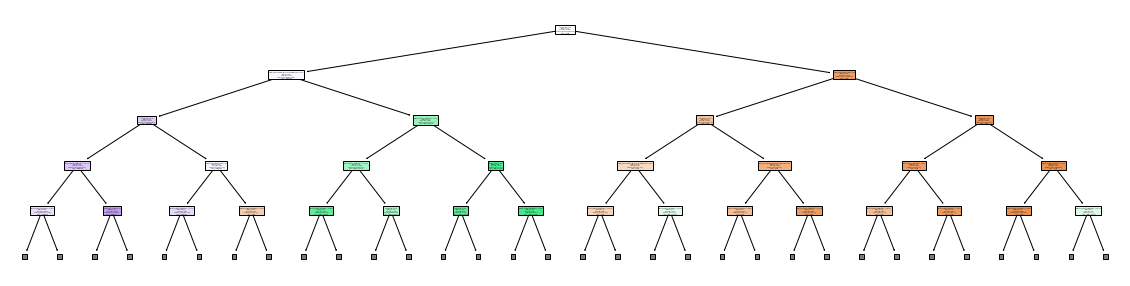

In [60]:
dt_best = DecisionTreeClassifier(max_depth=5, random_state=0)
dt_best = dt_best.fit(X_train, y_train)
plot_tree(dt_best, feature_names=df.drop(columns=['Outcome1']).columns, class_names=dt_best.classes_, filled=True, max_depth=4)
plt.show()

<AxesSubplot:>

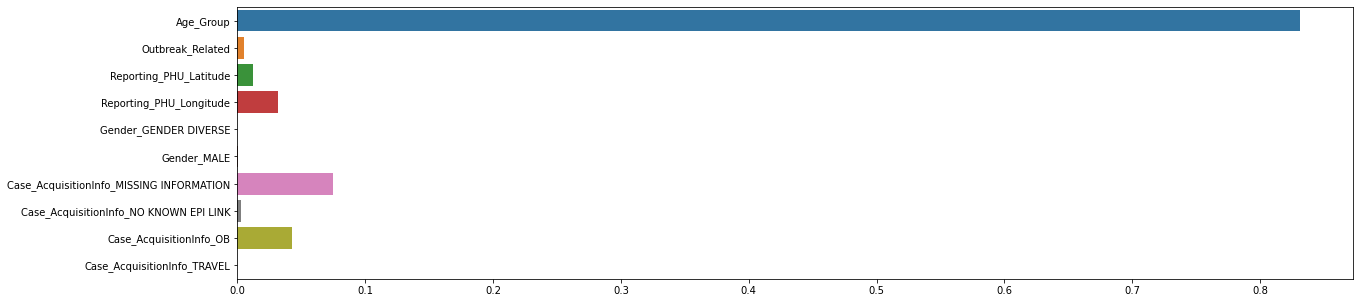

In [61]:
sns.barplot(dt_best.feature_importances_, df.drop(columns=['Outcome1']).columns)

1. Based on the decision tree, it can be seen that `Age_Group` is the most important feature giving the highest normalized reduction in the information criteria (gini importance in this case). It can be seen that if the `Age_Group` is greater than 5.5 (60s or less), it is more likely that the `Outcome1` is Fatal.

2. If a case is associated with an outbreak, then it is also a very determinant feature as it associated with Fatal cases.

3. It can be seen that latitude and longitude values are showing some importance in splitting going deeper into the tree. This indicates that `Reporting_PHU_City` is also a determinant of our target variable.

4. If there is missing information on case acquisition, it also seen to be very important in determining splits. (Although I am very skeptical about what information is this really giving us. I have just included this for the sake of the assignment.)

#### Random Forests

In [62]:
def cross_validate_random_forest_tree(X_train, y_train, n_estimators, max_depths, min_samples_split=2, min_samples_leaf=2, random_state=0, folds = 10):
    training_accuracy = []
    mean_cv_accuracy = []
    for max_depth in max_depths:
        for size in n_estimators:
            if max_depth == "None":
                max_depth = None

            dt_init = RandomForestClassifier(n_estimators = size,
            criterion='gini',
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=0)

            cv_scores = cross_val_score(dt_init, X_train, y_train, cv=folds)
            mean_cv_accuracy.append(cv_scores.mean()) 
            training_accuracy.append(dt_init.fit(X_train, y_train).score(X_train, y_train))


    return mean_cv_accuracy, training_accuracy

In [63]:
max_depths = [3, 5, 10, "None"]
n_estimators = [5, 10, 50, 150, 200]
mean_cv_accuracy, training_accuracy = cross_validate_random_forest_tree(X_train, y_train, n_estimators, max_depths)

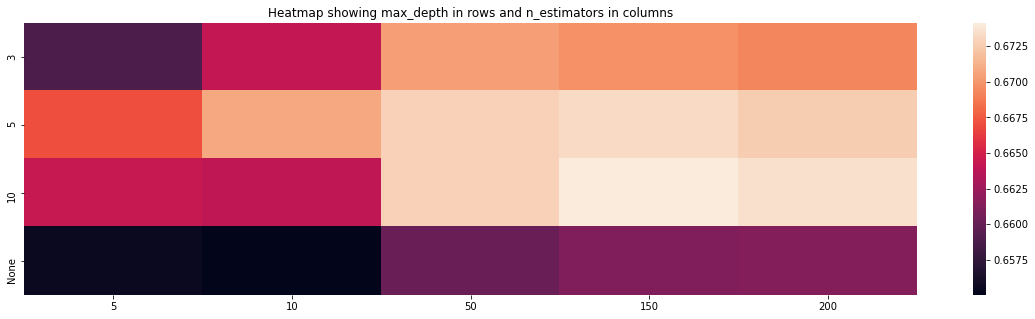

In [16]:
df_heat = pd.DataFrame(np.array(mean_cv_accuracy).reshape(-1, len(n_estimators)), index=max_depths, columns=n_estimators)
sns.heatmap(df_heat).set_title("Heatmap showing max_depth in rows and n_estimators in columns")
pass

This shows that the optimal combination of the two hyperparamters is (max_depth, n_estimators) = (10, 150).

In [64]:
rf_best = RandomForestClassifier(n_estimators = 150,
                                criterion='gini',
                                max_depth=10,
                                min_samples_split=2,
                                min_samples_leaf=2,
                                random_state=0)
rf_best = rf_best.fit(X_train, y_train)

<AxesSubplot:>

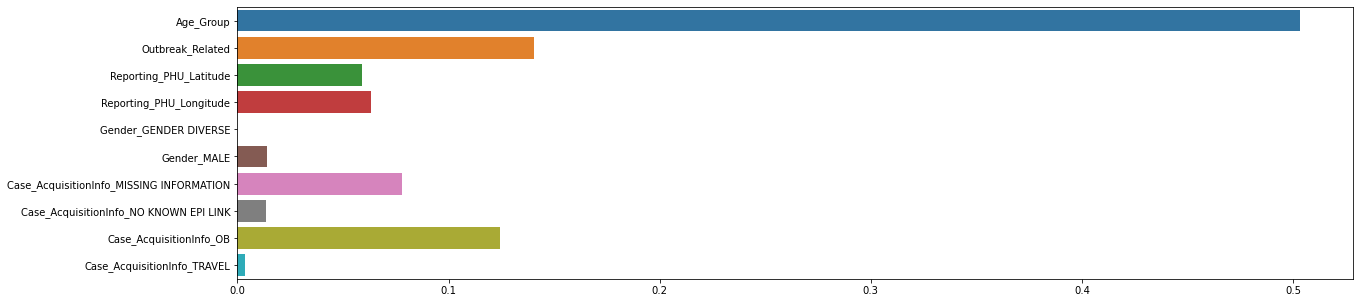

In [65]:
sns.barplot(rf_best.feature_importances_, df.drop(columns=['Outcome1']).columns)

Now, we have a better estimate of the feature importance since we are ensembling the decision trees which reduces the variance of the model. Interestingly, the feature importance of `Age_Group` is somewhat decreased as compared to the previous standalone DT model whereas that of other features seems to be amplified. In particular, we can see a better impact of `Outbreak_Related` as comapred to the Decision Tree model.

#### Gradient Tree Boosting

In [66]:
def cross_validate_gradient_boosting_tree(X_train, y_train, n_estimators, random_state=0, folds = 10):
    training_accuracy = []
    mean_cv_accuracy = []
    for size in n_estimators:
            gbt_init = GradientBoostingClassifier(n_estimators = size,
            random_state=random_state)
            cv_scores = cross_val_score(gbt_init, X_train, y_train, cv=folds)
            mean_cv_accuracy.append(cv_scores.mean()) 
            training_accuracy.append(gbt_init.fit(X_train, y_train).score(X_train, y_train))

    return mean_cv_accuracy, training_accuracy

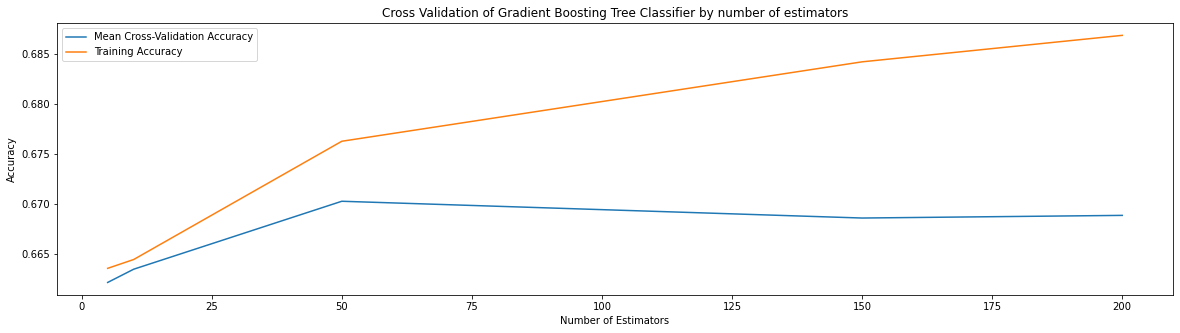

In [67]:
n_estimators = [5, 10, 50, 150, 200]
mean_cv_accuracy, training_accuracy = cross_validate_gradient_boosting_tree(X_train, y_train, n_estimators, random_state=0, folds = 10)
plt.plot(n_estimators, mean_cv_accuracy)
plt.plot(n_estimators, training_accuracy)
plt.title("Cross Validation of Gradient Boosting Tree Classifier by number of estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.legend(['Mean Cross-Validation Accuracy', 'Training Accuracy'])

Based on this graph, we can see that increasing estimators increases both training and validation accuracy but the former, with a much higher rate. Based on the discussions here (https://stats.stackexchange.com/questions/294661/train-vs-test-error-gap-and-its-relationship-to-overfitting-reconciling-confli) and here (https://stats.stackexchange.com/questions/156694/how-can-training-and-testing-error-comparisons-be-indicative-of-overfitting), I conclude that the increasing gap does not indicate over-fitting.

EDIT: On my final run, the cross validation accuracy actually decreased after 50 so I am simply taken this as the optimal hyperparameter.

<AxesSubplot:>

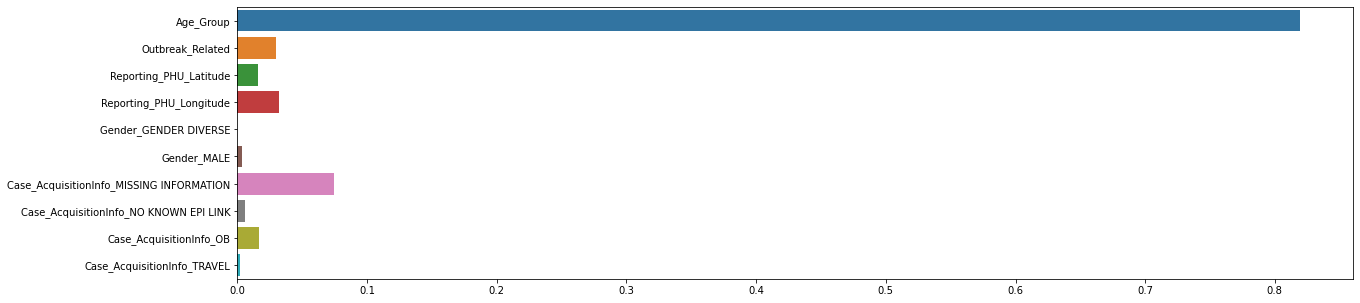

In [68]:
gbt_best = GradientBoostingClassifier(n_estimators = 50, random_state=0).fit(X_train, y_train)
sns.barplot(gbt_best.feature_importances_, df.drop(columns=['Outcome1']).columns)

The feature's importance seems to be quite consistent with the DT and Random Forest models as seen previously.

## Part 2

### CM3

#### Dataset 2

The performance of the tuned models on the test set are compared below.

In [69]:
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

       Fatal       0.79      0.88      0.83       940
Not Resolved       0.64      0.35      0.45       934
    Resolved       0.54      0.73      0.62       957

    accuracy                           0.65      2831
   macro avg       0.66      0.65      0.64      2831
weighted avg       0.66      0.65      0.64      2831



In [70]:
print(classification_report(y_test, rf_best.predict(X_test)))

              precision    recall  f1-score   support

       Fatal       0.80      0.88      0.83       940
Not Resolved       0.59      0.45      0.51       934
    Resolved       0.57      0.64      0.61       957

    accuracy                           0.66      2831
   macro avg       0.65      0.66      0.65      2831
weighted avg       0.65      0.66      0.65      2831



In [71]:
print(classification_report(y_test, gbt_best.predict(X_test)))

              precision    recall  f1-score   support

       Fatal       0.79      0.89      0.83       940
Not Resolved       0.61      0.43      0.51       934
    Resolved       0.56      0.65      0.60       957

    accuracy                           0.66      2831
   macro avg       0.65      0.66      0.65      2831
weighted avg       0.65      0.66      0.65      2831



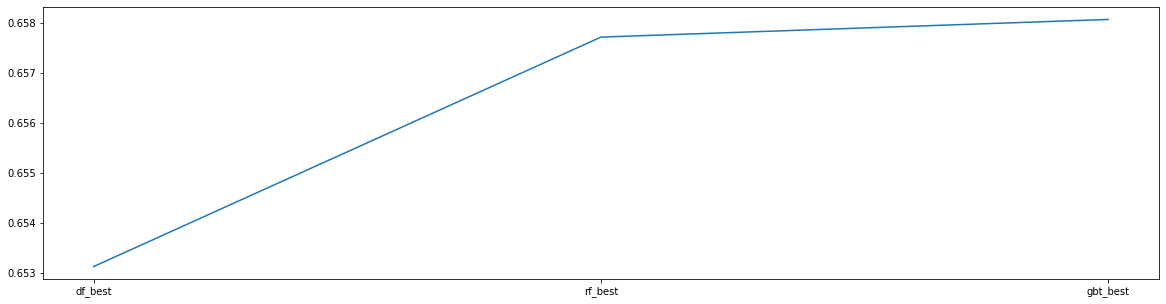

In [78]:
test_accuracies = []
test_models = ["df_best", "rf_best", "gbt_best"]
models = [dt_best, rf_best, gbt_best]

for model in models:
    test_accuracies.append(model.score(X_test, y_test))

plt.plot(test_models, test_accuracies)

> Practically speaking, this is a very poor technique of plotting since the y-axis has been limited by a lot.

As can be seen, the models perform fairly similar to each other with GBT performing only "slightly" better. However, in terms of F1-Score, it can be seen that DT performs slightly worse.

It was expected that RF would perform better than DT as the ensemble of trees reduces the model variance (while keeping the bias the same as a single tree). Comparing RF to GBT, as it is generally said that boosting can lead to better performance than RF "if" the hyperparamters are carefully tuned. One explanation to this is that while RF models increase performance by reducing variance only, GBT models decrease both, the bias as well as variance.

## Part 3

#### Kaggle Submission

In [118]:
df = pd.read_csv(r"input/covid_tests.csv")
df.head()

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,80s,FEMALE,MISSING INFORMATION,Toronto,NaN,43.656591,-79.379358
1,80s,MALE,NO KNOWN EPI LINK,Toronto,Yes,43.656591,-79.379358
2,40s,FEMALE,OB,Stratford,Yes,43.368662,-81.001913
3,30s,MALE,NO KNOWN EPI LINK,Mississauga,NaN,43.647471,-79.708893
4,60s,MALE,NO KNOWN EPI LINK,London,NaN,42.981468,-81.254016


In [119]:
df.loc[df['Outbreak_Related'].isna(),'Outbreak_Related'] = "No"

# Commenting this out as I am not sure whether do we have

## Adding this filter based on TA's comments in @404
#df.loc[df['Client_Gender'] == "UNSPECIFIED", 'Client_Gender'] = np.nan
#df = df.dropna()

# Combining based on personal intuition as stated previously
df.loc[df['Case_AcquisitionInfo'] == "UNSPECIFIED EPI LINK", "Case_AcquisitionInfo"] = "MISSING INFORMATION"

# Using the age_encoder built using training set
df['Age_Group'] = age_encoder.transform(np.array(df['Age_Group']).reshape(-1 ,1))
df['Outbreak_Related'] = pd.get_dummies(df['Outbreak_Related'], drop_first=True)

# Preprocessing Specific to DT
df = df.drop(columns=['Reporting_PHU_City'])
df = pd.concat([df.drop(columns=['Client_Gender']), pd.get_dummies(df['Client_Gender'], prefix='Gender', drop_first=True)], axis=1)
df = pd.concat([df.drop(columns=['Case_AcquisitionInfo']), pd.get_dummies(df['Case_AcquisitionInfo'], prefix='Case_AcquisitionInfo', drop_first=True)], axis=1)
df.head()

,Age_Group,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Gender_MALE,Gender_UNSPECIFIED,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL
0,7.0,0,43.656591,-79.379358,0,0,1,0,0,0
1,7.0,1,43.656591,-79.379358,1,0,0,1,0,0
2,3.0,1,43.368662,-81.001913,0,0,0,0,1,0
3,2.0,0,43.647471,-79.708893,1,0,0,1,0,0
4,5.0,0,42.981468,-81.254016,1,0,0,1,0,0


In [120]:
output = pd.DataFrame(gbt_best.predict(df)).reset_index()
output.columns = ['id', 'Outcome1']
output.to_csv("kaggle_submission_covid.csv", index=False)
output

,id,Outcome1
0,0,Fatal
1,1,Fatal
2,2,Not Resolved
3,3,Resolved
4,4,Resolved
...,...,...
3708,3708,Fatal
3709,3709,Not Resolved
3710,3710,Fatal
3711,3711,Fatal


# Question 2

## Part 1

### CM5

#### Dataset 2

#### Applying Naive Bayes to a dataset with a mix of nominal, ordinal and continuous

Major variants of NB assume gaussian, binomial (or to say, bernoulli) and multinomial distribution of the features giving us GaussianNB, BernoulliNB and CategoricalNB. Scikit-learn's implementation of Naive Bayes require all features of the same type i.e any one of gaussian, binomial or multinomial. 

One thing that needs to be kept in mind is the conditional assumption of independence that NB makes. If I encode my categorical variables as dummy variables, they would be anything but independent. Therefore, we have to make sure that we are not violating that assumption.

To address this issue, there are a few options such as:

1. Write the algorithm from scratch, treating each feature according to their type.
2. Use mixed-naive-bayes package that implements the 1st option.
3. Train separate scikit-learn models (gaussian, bi/multinomial) for each type of features and multiply the output probability of each to get the "complete" probability for class assignment (Going back to the definition and assumption of conditional independence of Naive Bayes). Note that multiplying posterior probabilities of two NB classifiers does require normalizing with prior probability to avoid a squared prior in the numerator. This is optional I would say since an additional prior multiplier will only scale the posterior probabilities.
4. Again train separate scikit-learn models (gaussian, bi/multinomial) for each type of features but this time, instead of multiplying them, treat the class assignment probabilities of the trained models as "new features" and then fit another Guassian on these new features to get predictions.
5. Discretize my continous variables and treat all the features as categorical and train a CategoricalNB classifier.

My Solution:
In this case, since my only continuous features are latitude/longitude, I already have their "discretized" form as the `Reporting_PHU_City`. I, therefore, decide to drop the lat/long features, and train my model using CategoricalNB (of course without creating dummy variables, firstly, because I don't need a dummy format for CategoricalNB, and secondly, because that would violate the Naive Baye's assumption of conditional independence.)

#### Preprocessing for NB

Note: I am encoding `Client_Gender` , `Case_AcquisitionInfo` and `Reporting_PHU_City` into numerical form. This is not ordinal encoding as the features are not ordinal. The CategoricalNB just wants categories to be in the form numeric just for the purpose of computations and that is achieved using label encoding.

One assumption is that `Client_Gender` and `Case_AcquisitionInfo` have a set of pre-defined categories in the system and therefore can be pre-coded using a LabelEncoder() before train/test split.

However for `Reporting_PHU_City`, I assume that there can be cities in my test set that my current training data does not include. For this, I can only encode after train/test split using the training set. Any new/unseen city in the testing set will be encoded to as Unknown/Other. However, the LabelEncoder() implementation of scikit-learn does not handle unseen data very well and therefore, it is usually recommended not to use it on the input data. In order to address that issue, I am using an extended form of LabelEncoder() implemented by https://stackoverflow.com/users/1587156/vinoj-john-hosan and further extended by myself.

In [80]:
df_NB = df_NB.drop(columns=['Reporting_PHU_Latitude', 'Reporting_PHU_Longitude'])

gender_encoder = LabelEncoder()
df_NB['Client_Gender']= gender_encoder.fit_transform(df_NB['Client_Gender'])

acq_encoder = LabelEncoder()
df_NB['Case_AcquisitionInfo']= acq_encoder.fit_transform(df_NB['Case_AcquisitionInfo']) 

df_NB

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Outcome1
0,4.0,2,2,Oakville,0,Resolved
1,1.0,0,0,Guelph,0,Not Resolved
2,8.0,0,3,Barrie,1,Resolved
3,1.0,0,1,Toronto,0,Resolved
4,8.0,0,3,Ottawa,1,Fatal
...,...,...,...,...,...,...
14846,0.0,0,0,Hamilton,0,Not Resolved
14847,1.0,0,2,Mississauga,0,Not Resolved
14848,7.0,2,3,Thorold,1,Fatal
14849,4.0,0,0,Newmarket,0,Fatal


#### Train Test Split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df_NB.drop(columns=['Outcome1']), df_NB['Outcome1'], test_size = 0.2, random_state=0)

#### Further pre-processing training set

In [82]:
city_encoder = LabelEncoderExt().fit(X_train['Reporting_PHU_City'])
X_train['Reporting_PHU_City'] = city_encoder.transform(X_train['Reporting_PHU_City']) 
X_train

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related
3455,7.0,0,3,30,1
6941,3.0,0,3,11,1
6263,5.0,0,1,30,0
11165,1.0,0,0,11,1
6500,7.0,0,3,6,1
...,...,...,...,...,...
13222,2.0,0,4,15,0
3299,7.0,2,3,33,1
9923,2.0,2,2,13,0
10880,1.0,0,1,34,0


In [83]:
def cross_validate_cnb(X_train, y_train, alpha_smoothings, folds = 10):
    training_accuracy = []
    mean_cv_accuracy = []
    for alpha_smoothing in alpha_smoothings:
            gnb_init = CategoricalNB(alpha = alpha_smoothing)
            cv_scores = cross_val_score(gnb_init, X_train, y_train, cv=folds)
            mean_cv_accuracy.append(cv_scores.mean()) 
            training_accuracy.append(gnb_init.fit(X_train, y_train).score(X_train, y_train))

    return mean_cv_accuracy, training_accuracy

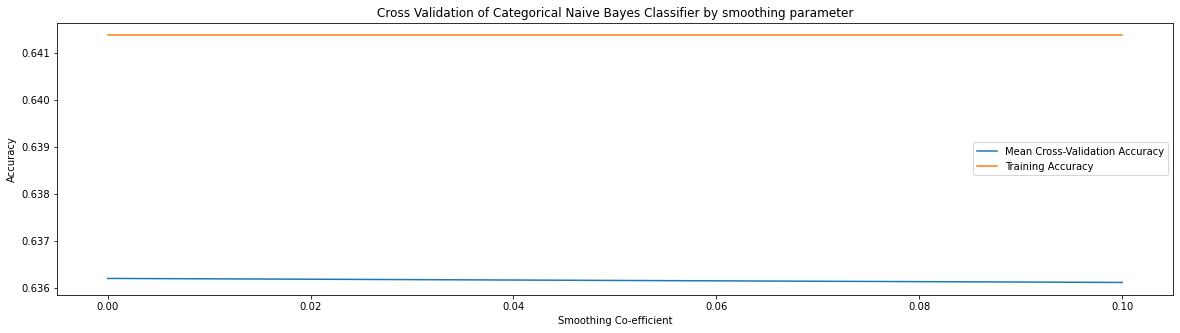

In [84]:
alpha_smoothings = [1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
mean_cv_accuracy, training_accuracy = cross_validate_cnb(X_train, y_train, alpha_smoothings, folds = 10)
plt.plot(alpha_smoothings, mean_cv_accuracy)
plt.plot(alpha_smoothings, training_accuracy)
plt.title("Cross Validation of Categorical Naive Bayes Classifier by smoothing parameter")
plt.xlabel("Smoothing Co-efficient")
plt.ylabel("Accuracy")
plt.legend(['Mean Cross-Validation Accuracy', 'Training Accuracy'])

Since the smoothing paramters provided in the assignment were suitable for GaussianNB's var_smoothing, I also experiment with more appropriate values of "Laplace/Lindstone" smoothing for CategoricalNB.

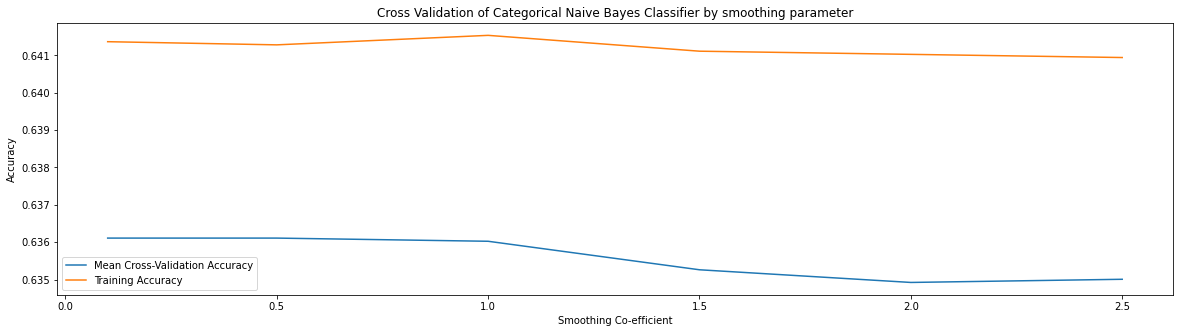

In [85]:
alpha_smoothings = [0.1, 0.5, 1, 1.5, 2, 2.5]
mean_cv_accuracy, training_accuracy = cross_validate_cnb(X_train, y_train, alpha_smoothings, folds = 10)
plt.plot(alpha_smoothings, mean_cv_accuracy)
plt.plot(alpha_smoothings, training_accuracy)
plt.title("Cross Validation of Categorical Naive Bayes Classifier by smoothing parameter")
plt.xlabel("Smoothing Co-efficient")
plt.ylabel("Accuracy")
plt.legend(['Mean Cross-Validation Accuracy', 'Training Accuracy'])

As can be seen from the above graph, the greater the smoothing co-efficient, the validation accuracy keeps on decreasing. It decreases with a greater rate when alpha is increased beyond 1. Whereas, the training accuracy is best observed at alpha = 1. The smoothing co-efficient is basically the Laplace/Lidstone co-efficient that helps us solve the problem of zero probability of the naive bayes theorem. Although the validation accuracy decreases from 0 to 1, the decrease is negligible and is not sufficient to convince me that no smoothing is required. I therefore, choose an alpha of 0.5 to train my best model.

In [86]:
cnb_best = CategoricalNB(alpha=0.5)
cnb_best.fit(X_train, y_train)

CategoricalNB(alpha=0.5)

## Part 2

### CM6

#### Dataset 2

In [87]:
def visualize_cnb_log_prob(model, title, features, rows, cols, figsize, encoders_dict=None):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
    fig.suptitle(title)

    for i in range(len(features)):
        if encoders_dict:
            if features[i] in encoders_dict:
                feature_levels = np.array([i for i in range(model.feature_log_prob_[i].shape[1])]).reshape(-1, 1)
                column_names = np.array(encoders_dict[features[i]].inverse_transform(feature_levels)).reshape(1,-1)[0]
            else:
                column_names = [i for i in range(model.feature_log_prob_[i].shape[1])]

        df = pd.DataFrame(model.feature_log_prob_[i], index=cnb_best.classes_, columns=column_names)
        sns.heatmap(df, ax = axes[i]).set_title(features[i])

In [88]:
encoders_dict = {
    "Age_Group": age_encoder,
    "Client_Gender": gender_encoder,
    "Case_AcquisitionInfo": acq_encoder,
    "Reporting_PHU_City": city_encoder
}

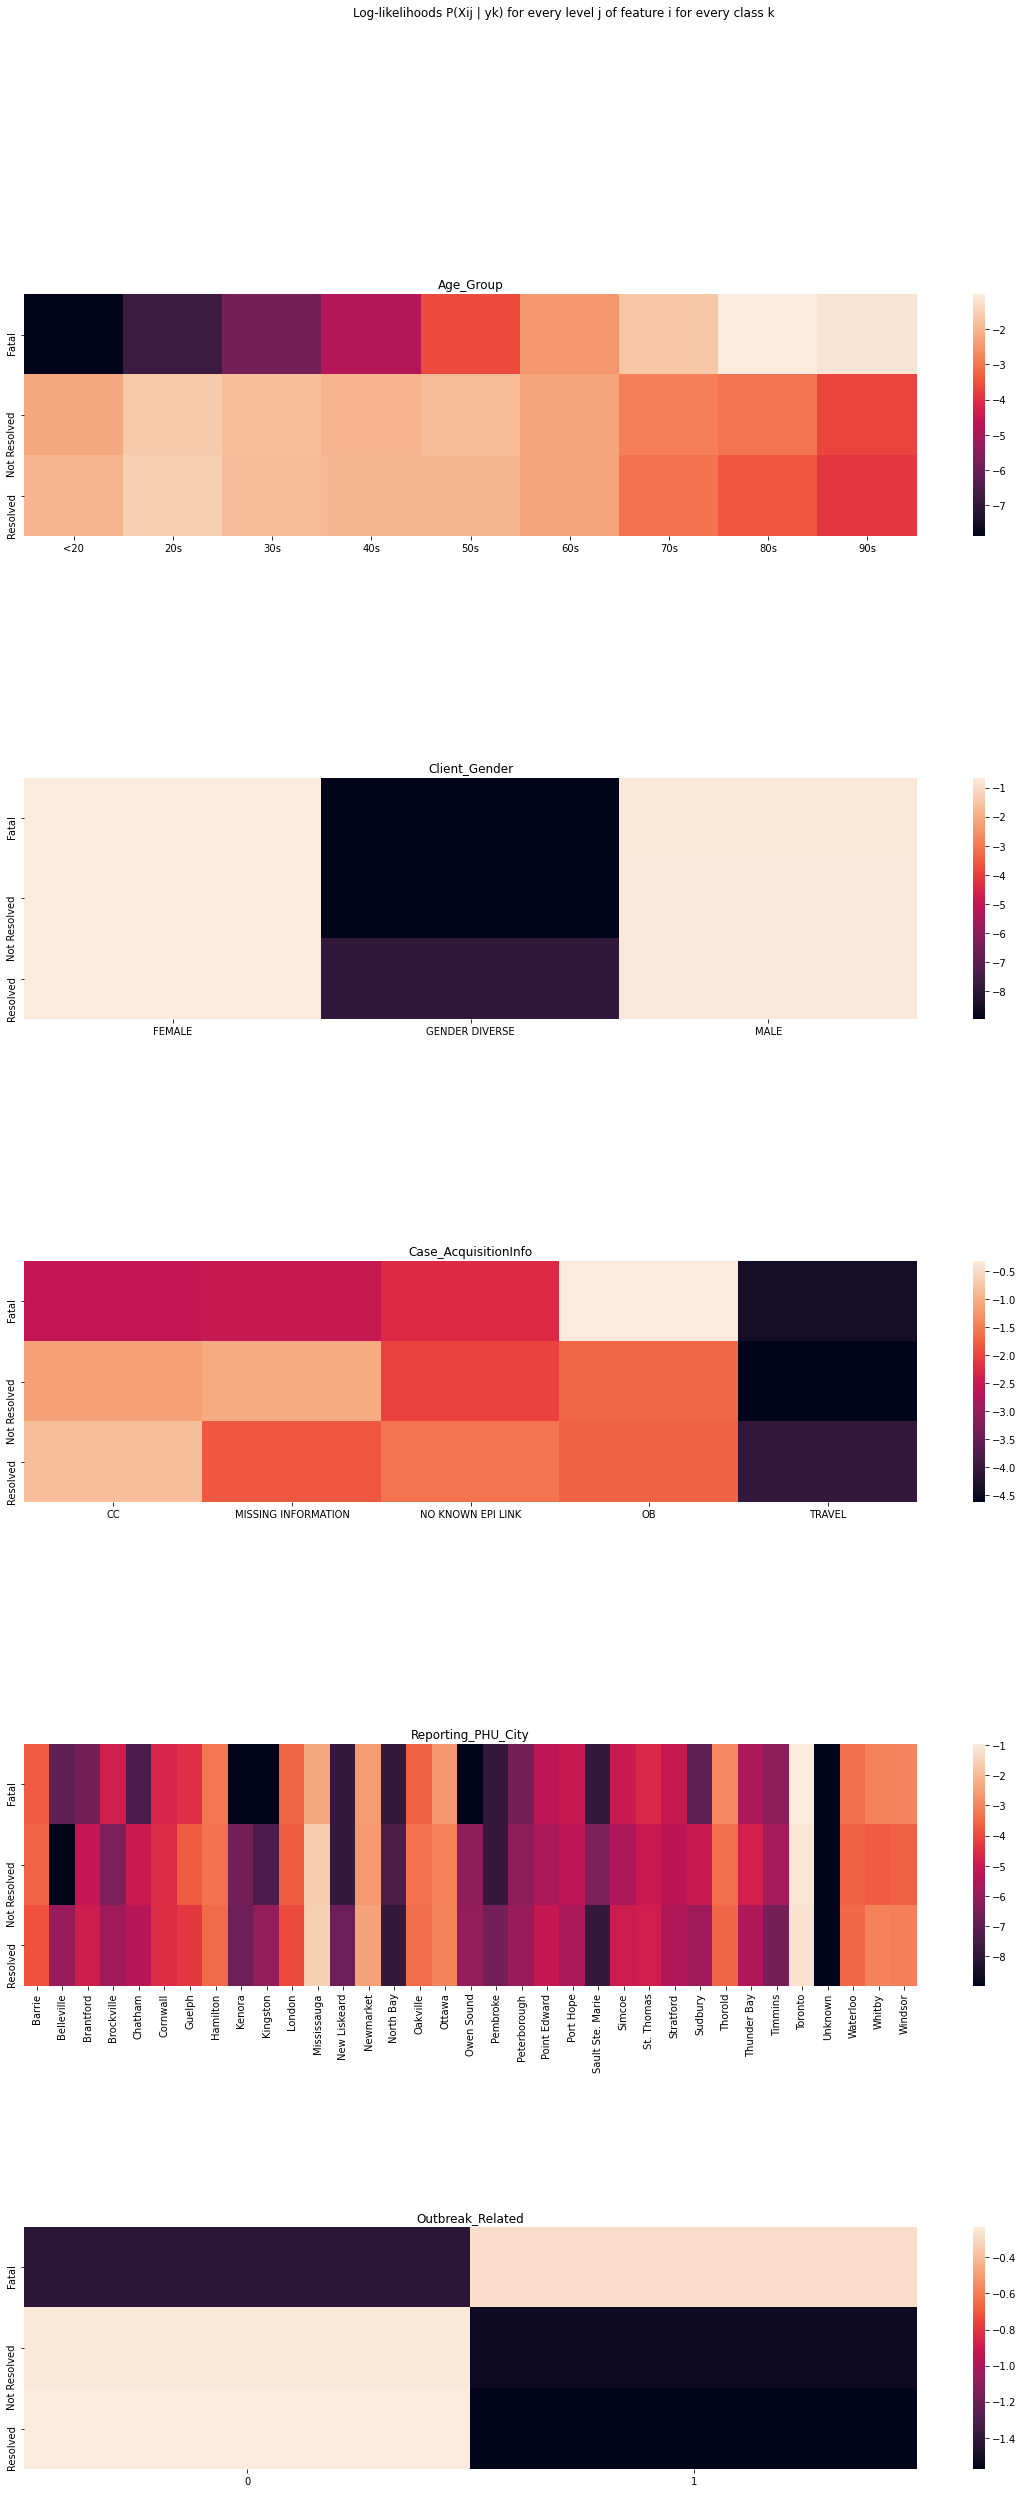

In [89]:
visualize_cnb_log_prob(cnb_best, "Log-likelihoods P(Xij | yk) for every level j of feature i for every class k", X_train.columns, rows=5, cols=1, figsize=(20,40), encoders_dict=encoders_dict)

#### Interpretation of Likelihoods

From these graphs, it can be inferred that based on the likelihoods:

1. If it's a fatal case, then there is more probability that age lies in older ranges. The relation is opposite for Resolved and Not Resolved cases.
2. For every type of case, the likelihood of a diverse gender is very small which is due to its very low frequency.
3. If it's a fatal case, there is more probability that the case is OB. If it's Resolved, then the cause is most probably Missing or Close Contact. If it's Resolved, then CC is most probable.
4. For every given type of case, toronto is the most probably city. For Resolved and Not Resolved, Missisauga is also quite probable, second to Toronto.
5. If a case is Fatal, it's more probable that the case was Outbreak Related. Whereas, an opposite relation is observed for Resolved and Not Resolved.

#### Comparison to Decision Tree Splits

In view of these likelihood probabilities and the decision tree splits, a few common patterns can be observed:

1. Higher age groups seem to be associated with more fatal cases.
2. Fatality is associated to outbreaks.
3. Cases with missing information on acquisitions being more likely to be unresolved.


#### Testing

In [90]:
X_test['Reporting_PHU_City'] = city_encoder.transform(X_test['Reporting_PHU_City']) 

In [91]:
print(classification_report(y_test, cnb_best.predict(X_test)))

              precision    recall  f1-score   support

       Fatal       0.80      0.80      0.80       987
Not Resolved       0.58      0.44      0.50       974
    Resolved       0.54      0.66      0.59       988

    accuracy                           0.64      2949
   macro avg       0.64      0.63      0.63      2949
weighted avg       0.64      0.64      0.63      2949



#### Model Performance Comparison

Text(0.5, 1.0, 'Comparison of Model Accuracy')

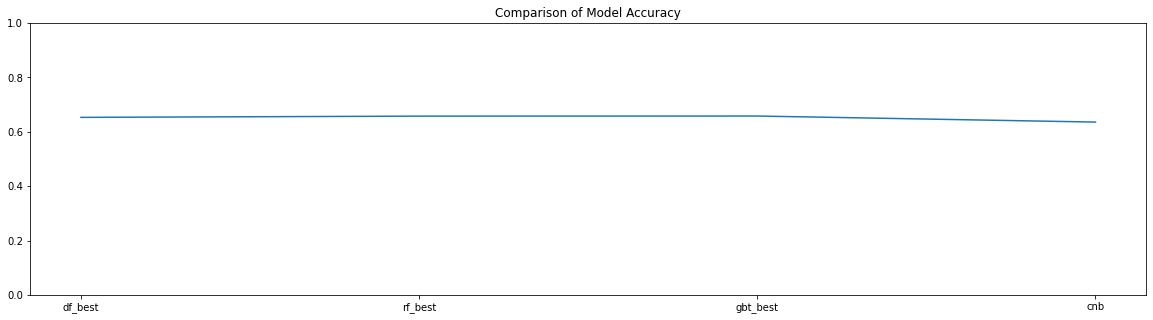

In [92]:
test_accuracies.append(cnb_best.score(X_test, y_test))
test_models.append("cnb")
plt.plot(test_models, test_accuracies)
plt.ylim([0, 1])
plt.title("Comparison of Model Accuracy")

As can be seen from this graph, the performance of all the four models are quite similar, with GBT performing slightly better than the rest and Naive Bayes performing only slighly worse. But given the training times, Naive Bayes does a pretty good job in my opinion.